In [24]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import glob
%matplotlib inline
device = "cuda"

In [2]:
model = torchvision.models.vgg16(pretrained=True)
#ロスの計算にはVGGを用いる
model.eval()
model = model.to(device)
#0-3 conv1 5-8 conv2 10-15 conv3 17-22 conv4 24-29 conv5 
conv1_2 = nn.Sequential(*list(model.features)[0:4])
conv2_2 = nn.Sequential(*list(model.features)[4:9])
conv3_3 = nn.Sequential(*list(model.features)[9:16])
conv4_3 = nn.Sequential(*list(model.features)[16:23])
#モデルを使うとこまでで切り分け
print(conv1_2)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)


In [47]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#前処理はリサイズのみ

torch.Size([3, 256, 256])


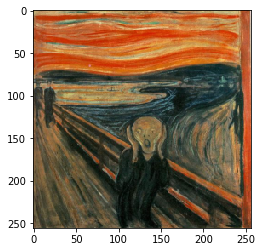

In [48]:
#style_img = preprocess(Image.open("../text19/img/wave-style.jpg"))
style_img = preprocess(Image.open("../text19/img/scream-style.jpg"))
print(style_img.shape)
plt.imshow(style_img.numpy().transpose(1,2,0))
plt.show()
style_img = style_img.unsqueeze_(0)
style_img = style_img.to(device)
#style画像を読み込んで(!,3,256,256)に変形

In [53]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, folder, transform = None):
        self.transform = transform
        self.files = glob.glob(os.path.join(folder,'*.jpg'))
        self.images = []
        for fn in self.files:
            if len(self.images) >= 1000:
                break
            if len(self.images) % 100 == 0:
                print(len(self.images))
            try:
                image = Image.open(fn)
                if self.transform:
                    image = self.transform(image)
                if image.shape[0] != 3:
                    #gray画像は切り捨て
                    continue
            except IOError:
                continue
            self.images.append(image)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        out_data = self.images[idx]
        return out_data
dataset = Mydatasets("/export/data/dataset/COCO/train2014/",transform=preprocess)

0
100
200
300
400
500
600
700
800
900


In [94]:
class DownSamp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownSamp, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2,padding=1)
        #self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
        #self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        #self.bn2 = nn.BatchNorm2d(out_ch)
        #self.bn3 = nn.BatchNorm2d(out_ch)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu_(x)
        #x = self.conv2(x)
        #x = self.bn2(x)
        #x = F.relu_(x)
        #x = self.conv3(x)
        #x = self.bn3(x)
        #x = F.relu_(x)
        return x
class UpSamp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpSamp, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_ch,out_ch,kernel_size=4, stride=2,padding=1)
        #elf.conv1 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
        #lf.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
        
        self.bn1 = nn.BatchNorm2d(out_ch)
        #self.bn2 = nn.BatchNorm2d(out_ch)
        #self.bn3 = nn.BatchNorm2d(out_ch)
    def forward(self,x):
        x = self.deconv(x)
        x = self.bn1(x)
        x = F.relu_(x)
        #x = self.conv1(x)
        #x = self.bn2(x)
        #x = F.relu_(x)
        #x = self.conv2(x)
        #x = self.bn3(x)
        #x = F.relu_(x)
        return x
#https://deepage.net/deep_learning/2016/11/30/resnet.html
class ResNetBlock(nn.Module):
    def __init__(self, in_ch, hidden_ch):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, hidden_ch, kernel_size=1)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_ch, in_ch, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.bn3 = nn.BatchNorm2d(hidden_ch)
    def forward(self, x):
        res = x
        x = self.bn1(x)
        x = F.relu_(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = F.relu_(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = F.relu_(x)
        x = self.conv3(x)
        x = x + res
        return x
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.in1 = nn.Conv2d(3, 64, kernel_size=7,stride=1,padding=3)
        self.in2 = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=1)
        self.down1 = DownSamp(64,128)
        self.down2 = DownSamp(128,256)
        self.down3 = DownSamp(256,512)
        #self.down4 = DownSamp(512,1024)
        #self.up4 = UpSamp(1024,512,512)
        self.res1 = ResNetBlock(512,216)
        self.res2 = ResNetBlock(512,216)
        self.res3 = ResNetBlock(512,216)
        self.res4 = ResNetBlock(512,216)
        self.res5 = ResNetBlock(512,216)
        self.up3 = UpSamp(512,256)
        self.up2 = UpSamp(256,128)
        self.up1 = UpSamp(128,64)
        self.out = nn.Conv2d(64,3, kernel_size=7, stride=1, padding=3)
    def forward(self,x):
        x = self.in1(x)
        x = F.relu_(x)
        x = self.in2(x)
        x = F.relu_(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        #x5 = self.down4(x4)
        #x = self.up4(x5,x4)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.up3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.out(x)
        x = torch.sigmoid(x)
        return x

In [83]:
#メディア実験のプロット関数を少し書き換え
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def sample_images(generator,dataset):
    #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
    r, c = 2, 5
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=5,shuffle=False)
    
    imgs = next(iter(dataloader))
    generated = generator(imgs.to(device)).detach()
    gen_imgs = np.concatenate([imgs.cpu().numpy().transpose(0,2,3,1), generated.cpu().numpy().transpose(0,2,3,1)])


    titles = ['Input', 'Generated']
    fig, axs = plt.subplots(r, c, figsize=(10,6))
    cnt = 0
    for i in range(r):
       for j in range(c):
           axs[i,j].imshow(gen_imgs[cnt])
           axs[i,j].set_title(titles[i])
           axs[i,j].axis('off')
           cnt += 1
    
    display.clear_output(wait = True)
    display.display(fig)
    plt.close()

In [90]:
#グラム行列の計算
#(1,C,H,W)の特徴マップを(C,H+W)に変形してから転置したものと内積を取ることで
#(C,C)のグラム行列になる
#チャネル間に相関が強いほど大きい値になる
def gram(feature):
    c = feature.shape[1]
    feature = feature.view(c,-1)
    ret = feature.matmul(feature.T)
    return ret/feature.numel()

#style lossはスタイル画像の特徴マップのグラム行列と生成画像の特徴マップのグラム行列の
#2乗和
def calc_styleloss(x_convn, style_convn):
    return torch.sum((gram(x_convn)-gram(style_convn))**2)#/((x_convn.shape[1:].numel()))
#画像を下に1ピクセルずらしたものと画像の差、画像を右に1ピクセルずらしたものと画像の差に対して
#lossを加えることで滑らかさを考慮する
def calc_total_variation_loss(x):
    a = x[:,:,:-1,:-1] - x[:,:,1:,:-1]
    b = x[:,:,:-1,:-1] - x[:,:,1:,1:]
    return torch.sum((a**2 + b**2)**1.25)

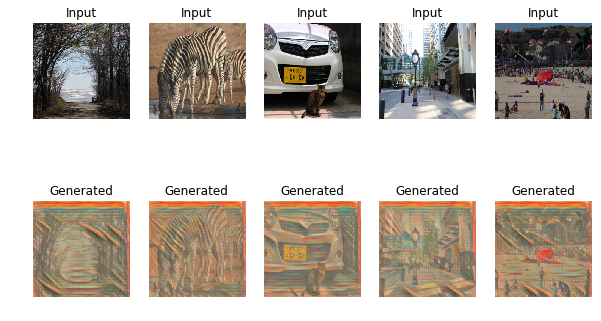

itr: 30000
content loss: 2.198331
style loss: 0.033656
total variant loss: 169.285675


In [95]:
style_conv1_2 = conv1_2(style_img).detach()
style_conv2_2 = conv2_2(style_conv1_2).detach()
style_conv3_3 = conv3_3(style_conv2_2).detach()
style_conv4_3 = conv4_3(style_conv3_3).detach()
#style画像の特徴マップをあらかじめ計算
generator = Generator().to(device)

optim = opt.Adam(params=generator.parameters())
#optimizerはAdamを用いる
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True)
#データローダの読み込み batch_sizeは5
itr=0
epoch=30
for ep in range(epoch):
    for img in dataloader:
        itr+=1
        content_img = img.to(device)
        content_conv3_3 = conv3_3(conv2_2(conv1_2(content_img))).detach()
        def closure():
            global x,l_content,l_style,l_total_v
            x = generator(content_img)
            #画像を変換
            x_conv1_2 = conv1_2(x)
            x_conv2_2 = conv2_2(x_conv1_2)
            x_conv3_3 = conv3_3(x_conv2_2)
            x_conv4_3 = conv4_3(x_conv3_3)
            #変換画像の特徴マップの計算

            l_content = torch.sum((x_conv3_3 - content_conv3_3)**2)/(x_conv3_3.shape[1:].numel())
            #content lossはcontent画像と変換画像の特徴マップのL1 loss
            l_s = []
            l_s.append(calc_styleloss(x_conv1_2, style_conv1_2))
            l_s.append(calc_styleloss(x_conv2_2, style_conv2_2))
            l_s.append(calc_styleloss(x_conv3_3, style_conv3_3))
            l_s.append(calc_styleloss(x_conv4_3, style_conv4_3))
            #style画像と変換画像のstyle loss を計算
            w_s = [1,1,1,1]
            l_style = 0
            for w,l in zip(w_s, l_s):
                l_style += w*l
            l_total_v = calc_total_variation_loss(x)
            loss =  l_content*0.025 + l_style + l_total_v*1e-4
            optim.zero_grad()
            loss.backward()
            return loss
        optim.step(closure)
        #重みの更新
    
        if itr % 100 == 0:
            sample_images(generator, dataset)
            #画像の表示 表示する画像は面倒だったのでtrainと同一
            print("itr: %d"%itr)
            print("content loss: %f"%l_content)
            print("style loss: %f"%l_style)
            print("total variant loss: %f"%l_total_v)
            #plt.imshow(x.detach().cpu().numpy().squeeze(0).transpose(1,2,0))
            #plt.show()


content lossとstyle lossの割合が難しく、style lossが低いとそのまま元の画像
を出力してしまい、style lossが高いとcontentが浮き出てこないので難しいと感じた。
また、実装を少し間違えただけでうまくいかないので気を付けて実装する必要があるなと感じた。

### 参考文献
Perceptual Losses for Real-Time Style Transfer and Super-Resolution https://arxiv.org/abs/1603.08155

Residual Network(ResNet)の理解とチューニングのベストプラクティス https://deepage.net/deep_learning/2016/11/30/resnet.html